<a href="https://colab.research.google.com/github/jokend1ng/jokend1ng/blob/main/foto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow as tf       
from tensorflow import keras
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image



Загружаем модель VGG16 




In [46]:
from traitlets.traitlets import Bytes
upl=files.upload()
img=Image.open(BytesIO(upl['img.jpg']))
img_style=Image.open(BytesIO(upl['img_style.jpg']))

Saving img.jpg to img (1).jpg
Saving img_style.jpg to img_style (1).jpg


Стандартизация данных

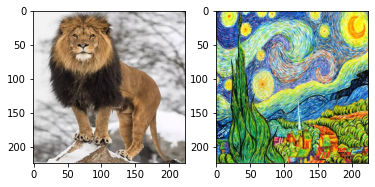

In [47]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_style)
plt.show()

In [48]:
x_img=keras.applications.vgg19.preprocess_input(np.expand_dims(img,axis=0))
x_style=keras.applications.vgg19.preprocess_input(np.expand_dims(img_style,axis=0))

Перевод из BGR в RGB

In [50]:
def deprocess_img(process_img):
  x=processed_img.copy()
  if len(x.shape)== 4:
    x=np.squeeze(x,0)
  assert len(x.shape)==3,("Input to deprocess image must be an image of"
  "dimension[1,height,width,channel] or [height,width,channel]")
  if len(x.shape) !=3:
    raise ValueError("Invalid input to deprocessing image")

  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68  
  x=x[:,:,::-1]   

  x=np.clip(x,0,255).astype('uint8')
  return x

In [51]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)
                

In [52]:
vgg=keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
vgg.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [53]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs=[vgg.get_layer(name).output for name in content_layers]
model_outputs=style_outputs+content_outputs

print(vgg.input)
for m in model_outputs:
    print(m)
model = keras.models.Model(vgg.input,model_outputs)
print(model.summary())    

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [54]:
def get_content_loss(base_content,target):
    return tf.reduce_mean(tf.square(base_content-target))
    

In [56]:
from tensorflow.python.ops.gen_array_ops import transpose
def gram_matrix(input_tensor):
    chanels=int(input_tensor.shape[-1])
    a=tf.reshape(input_tensor,[-1,channels])
    n=tf.shape(a)[0]
    gram=tf.matmul(a,a,transpose_a=True)
    return gram / tf.cast(n,tf.float32)

In [57]:
def get_style_loss(base_style,gram_target):
    gram_style=gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style-gram_target))

In [60]:
def compute_loss(model,loss_weights,init_image,gram_style_features,content_features):
    style_weight,content_weight=loss_weights
    model_outputs=model(init_image)

    style_outputs_features=model_outputs[:num_style_layers]
    content_output_features=model_outputs[num_style_layers:]
    style_score=0
    content_score=0

    weight_per_style_layer=1.0/float(num_style_layers)
    for target_style,comb_style in zip(gram_style_features,style_outputs_features):
        style_score+=weight_per_style_layer*get_style_loss(comb_style[0],target_style)
    weight_per_content_layer=1.0/float(num_content_layers)
    for target_content,comb_content in zip(content_features,content_output_features):
        content_score+=weight_per_content_layer*get_content_loss(comb_content[0],target_content)

   style_score *= style_weight
   content_score *= content_weight

   loss=style_score+content_score
   return loss,style_score,content_score         



IndentationError: ignored